# How to simulate missing values in Python?
Thomas Schmitt, Sept. 2019

## Intro

Assessing the performance of a model which deals with missing values requires to be able to generate such missing entries in the data, in order to have ground truth information.

In this notebook we consider three ways to ampute a dataset, which means replacing some values with `np.nan`.

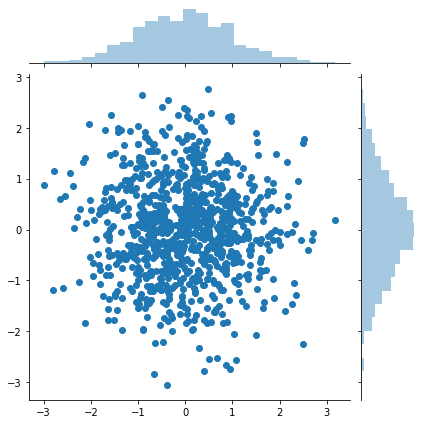

In [1]:
# first let's generate the complete data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(0)  # fix the seed 

n_samples = 900

# Generate normal data with no covariance.
mean = (0,0)
cov = [[1,0],[0,1]]
X_complete = np.random.multivariate_normal(mean, cov, size=n_samples)
# X_complete = np.random.uniform(0, 1, size=(n_samples,2))

sns.jointplot(X_complete[:,0], X_complete[:,1], label = 'Complete data');

# Amputation

We want to simulate a matrix `X_obs` from `X_complete` with missing entries (remplacing some entries by `np.nan`).  
To do so we sample a missing pattern matrix `M` with same shape as `X_complete` indicating missing entries:  

$X_{obs} = X_{complete} \cdot \mathbb{1}_{\{M=0\}} + \mbox{np.nan} \cdot \mathbb{1}_{\{M=1\}}$


The mechanisms generating missing values can be various but usually they are classified into three main categories defined by [Rubin 1976](https://www.jstor.org/stable/2335739)

1. Missing Completely at Random (MCAR)
1. Missing at Random (MAR)
1. Missing Not at Random (MNAR)  

The first two are also qualified as ignorable missing values mechanisms, for instance in likelihood-based approaches to handle missing values, whereas the MNAR mechanism generates nonignorable missing values.

## 1. MCAR Mechanism (Missing Completly at Random)

Values are Missing Completely At Random (MCAR) if the missingness pattern is independent of the values (observed or not). The probability of being missing does not depend on the data (neither $X_{obs}$ nor $X_{miss}$, where $X_{miss}$ correponds to the missing values.). Formally:  

$\mathbb{P} (M | X_{obs},X_{miss})= \mathbb{P}(M)\  \forall X_{obs},\  \forall X_{miss}$  
i.e. $M \perp \! \! \! \perp X_{complete} $  

In Python, the easiest way is to sample a Bernoulli to mask some data point

In [2]:
def ampute_mcar(X_complete, missing_rate = .2):
    # Mask completly at random some values
    M = np.random.binomial(1, missing_rate, size = X_complete.shape)
    X_obs = X_complete.copy()
    np.putmask(X_obs, M, np.nan)
    print('Percentage of newly generated missing values: {}'.\
      format(np.sum(np.isnan(X_obs))/X_obs.size))
    return X_obs

In [3]:
X_obs_mcar = ampute_mcar(X_complete)

Percentage of newly generated missing values: 0.1922222222222222


In [4]:
print('X_obs_mcar = ')
print(X_obs_mcar[:10])
print('  ...')

X_obs_mcar = 
[[ 1.76405235         nan]
 [ 0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788]
 [        nan         nan]
 [-0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [        nan -0.20515826]
 [        nan         nan]]
  ...


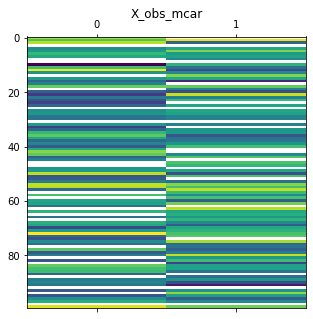

In [5]:
plt.figure(figsize=(5,5))
plt.matshow(X_obs_mcar[:100], aspect='auto', fignum=False)
plt.title('X_obs_mcar');

In [6]:
# More advanced ploting functions with seaborn
# scripts could be found at: https://github.com/R-miss-tastic/website/blob/master/static/how-to/python/utils_plot.py
from utils_plot import (hist_plot, scatter_plot_obs,
                        scatter_plot_with_missing_completed)

Data with "MCAR" mechanism.


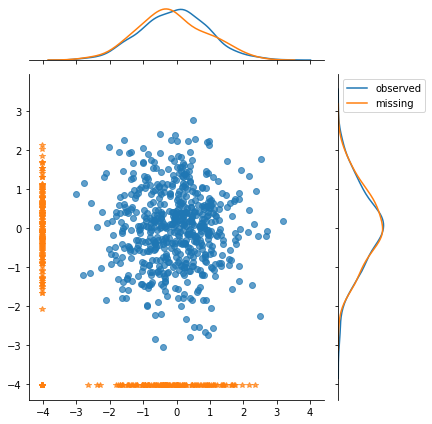

In [7]:
print('Data with "MCAR" mechanism.')
scatter_plot_obs(X_obs_mcar)

Plot completed with X_complete information.


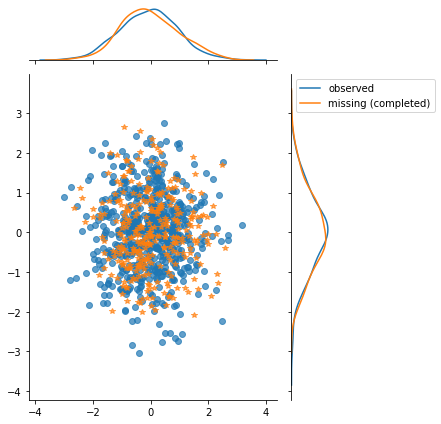

In [8]:
print('Plot completed with X_complete information.')
scatter_plot_with_missing_completed(X_obs_mcar, X_complete)

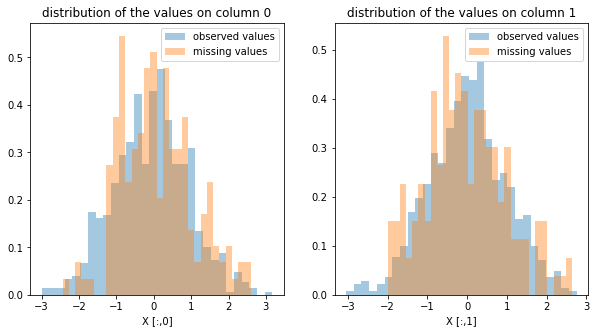

In [9]:
hist_plot(X_obs_mcar, X_complete)

From plots and histogram below, we can infer that missingness is independent on the observed and missing values.

## 2. MAR (Missing At Random)

The values are said to be Missing At Random (MAR) if the probability that an entry is missing only depends on the observed values `X_obs`. Formally,

$\mathbb{P} (M | X\_{obs},X\_{miss})= \mathbb{P}(M|X\_{obs}), \forall X\_{miss}$  
i.e. $M \perp \! \! \! \perp X_{miss} \ |\ X\_{obs}$    

In [10]:
from sklearn.preprocessing import normalize

def ampute_mar(X_complete, missing_rate=.2, W=None):
    """ Observed values censor the missing ones
    
    The proba of being missing: M_proba = X_obs.dot(W)
    So for each sample, some observed feature (P=1) will influence 
    the missingness of some others features (P=0).
    
    e.g. during a questionnary, those who said being busy (X_obs[:,0] = 1) 
    usualy miss to fill the last question (X_obs[:,-1] = np.nan)
    So here W[0,-1] = 1
    """
    X_obs = X_complete.copy()
    M_proba = np.zeros(X_obs.shape)
    
    if W is None:
        # generate the weigth matrix W
        W = np.random.randn(X_complete.shape[1], X_complete.shape[1])

    # Severals iteration to have room for high missing_rate
    for i in range(X_obs.shape[1]*2):
        # Sample a pattern matrix P
        # P[i,j] = 1 will correspond to an observed value
        # P[i,j] = 0 will correspond to a potential missing value
        P = np.random.binomial(1, .5, size=X_complete.shape)

        # potential missing entry do not take part of missingness computation
        X_not_missing = np.multiply(X_complete,P)

        sigma = np.var(X_not_missing)
        M_proba_ = np.random.normal(X_not_missing.dot(W), scale = sigma)

        # not missing should have M_proba = 0
        M_proba_ = np.multiply(M_proba_, 1-P)  # M_proba[P] = 0
        
        M_proba += M_proba_

    thresold = np.percentile(M_proba.ravel(), 100 * (1 - missing_rate))
    M = M_proba > thresold

    np.putmask(X_obs, M, np.nan)
    print('Percentage of newly generated missing values: {}'.\
      format(np.sum(np.isnan(X_obs))/X_obs.size))
    return X_obs

In [11]:
W = np.array([[0,10],[0,0]]) 
# With this weight matrix W, 
# missingness of X[:,1] depends on X[:,0] values
X_obs_mar = ampute_mar(X_complete, W=W)

Percentage of newly generated missing values: 0.2


Data with "MAR" mechanism.


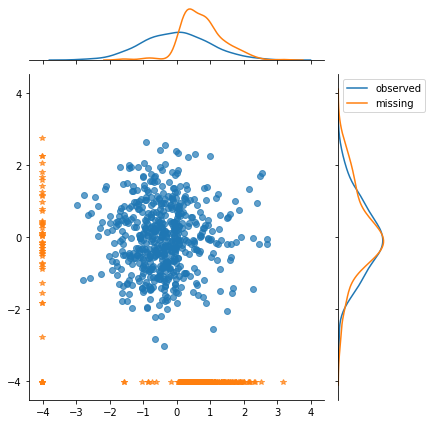

In [12]:
print('Data with "MAR" mechanism.')
scatter_plot_obs(X_obs_mar)

From the scatter plot we see that the missing values with `nan` on the `X[:,1]` coordinate (y-axis), which are represented as orange star at the bottom, are highly correlated to the `X[:,0]` values (x-axis). 

`X[i,0] > .5` => `X[i,1] = np.nan` with high probability.

Samples completed with X_complete information.


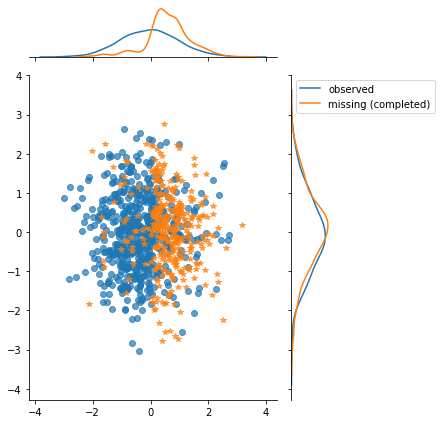

In [13]:
print('Samples completed with X_complete information.')
scatter_plot_with_missing_completed(X_obs_mar, X_complete)

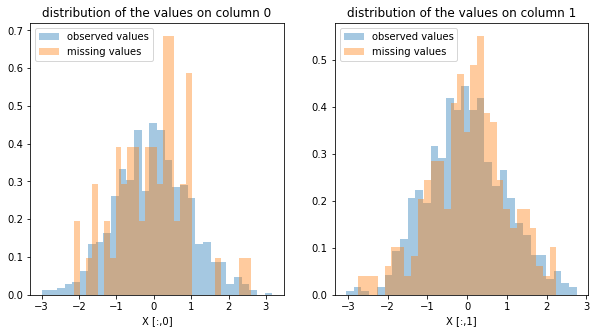

In [14]:
hist_plot(X_obs_mar, X_complete)

Histogram are overlapping : missingness does not depend on the missing values.

# MNAR (Missing Not At Random)

Otherwise, if neither MCAR nor MAR, values are Missing Not At Random (MNAR)
$\mathbb{P} (M | X\_obs, X\_mis)= \mathbb{P}(M|X\_obs), \forall X\_mis$

Here we ampute the highest values with highest probability. It might be called "censoring"

In [15]:
from scipy.special import expit as sigmoid  # logistic function

def ampute_mnar(X_complete, missing_rate= .2):
    """ ampute X_complete with censoring (Missing Not At Random)
    
    The missingness depends on the values.
    This will tends to "censor" X[i,j] where X[i,j] is high 
    comparing to its column X[:,j]
    """
    
    # M depends on X_complete values
    M_proba = np.random.normal(X_complete)
    M_proba = normalize(M_proba, norm='l1', axis=0)
    
    # compute thresold wrt missing_rate
    thresold = np.percentile(M_proba.ravel(), 100 * (1- missing_rate))
    M = M_proba > thresold
    
    X_obs = X_complete.copy()
    np.putmask(X_obs, M, np.nan)
    print('Percentage of newly generated missing values: {}'.\
      format(np.sum(np.isnan(X_obs))/X_obs.size))
    return X_obs

In [16]:
X_obs_mnar = ampute_mnar(X_complete)

Percentage of newly generated missing values: 0.2


X_obs with "MNAR" mechanism


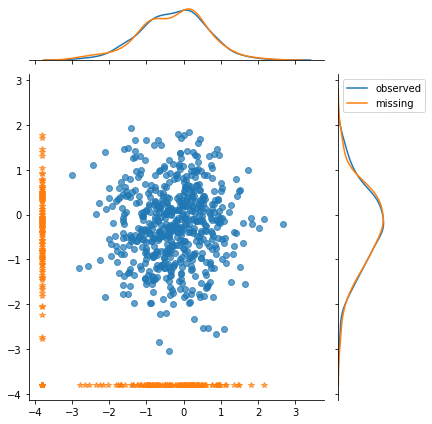

In [17]:
scatter_plot_obs(X_obs_mnar)
print('X_obs with "MNAR" mechanism')

Samples completed with X_complete information.


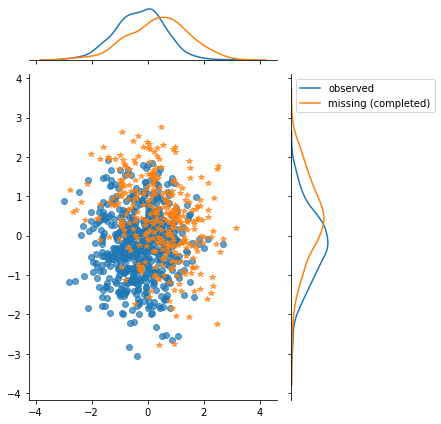

In [18]:
print('Samples completed with X_complete information.')
scatter_plot_with_missing_completed(X_obs_mnar, X_complete)

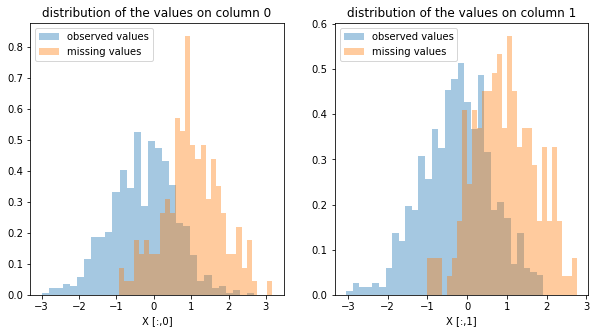

In [19]:
hist_plot(X_obs_mnar, X_complete)

The distribution of missing values is shifted to the right (comparing to the observed values' distribution).
The missingness pattern depends on the values of the missing entries.

# Summary

1. Mising completly at random (MCAR): the missingness mechanism could be forgotten, nan are distributed as white noise.
2. Missing at random (MAR): the missingness mechanism depends on the observed value (i.e. we should gain no additional information with a missing indicator, all information is in X_obs)
3. Missing not at random (MNAR): missingness might carry information about the missing values. Here having a missing indicator could be beneficial for learning.

### Additional remarks

For a commented bibliography we refer to the [R-miss-tastic website](https://rmisstastic.netlify.com/bibliography/).  

See also the R [ampute](https://rianneschouten.github.io/mice_ampute/vignette/ampute.html) algorithm from the R package [Mice](https://www.rdocumentation.org/packages/mice/versions/3.6.0/topics/mice)

We can also include the label `y` in the data. So the missingness could also depends on the target (We might call it "predictive missingness").